<img src="images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib radar data io and visualisation

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Examination of RadarVolume and Sweeps
1. Plotting of sweeps

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import numpy as np
import glob
import itertools

import wradlib as wrl
from matplotlib import ticker as tick
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Read data into RadarVolume

We have the special case with Rainbow5 data that the radar moments are splitted across files. Nevertheless each file consists of the complete volume of that particular moment.

We will use keywords to make the reader capable of consuming this data.

In [2]:
fglob = "data/wradlib/rainbow/meteoswiss/2019102108240900*.vol"

In [3]:
flist = sorted(glob.glob(fglob))
flist[0].split('/')[-1][:11]

'20191021082'

In [4]:
nflist = []
iterator = itertools.groupby(sorted(flist), lambda f: f.split('/')[-1][:11])
for element, group in iterator:
    nflist.append(list(group))

nflist[-1]

['data/wradlib/rainbow/meteoswiss/2019102108240900KDP.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900PhiDP.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900RhoHV.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900V.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900W.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900ZDR.vol',
 'data/wradlib/rainbow/meteoswiss/2019102108240900dBZ.vol']

In [5]:
%%time
vol = wrl.io.open_rainbow_mfdataset(nflist[-1], combine="by_coords", concat_dim=None)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1.86 s, sys: 9.98 ms, total: 1.87 s
Wall time: 1.86 s


## Examine RadarVolume

The RadarVolume is a shallow class which tries to comply to CfRadial2/WMO-FM301, see [WMO-CF_Extensions](https://community.wmo.int/activity-areas/wis/wmo-cf-extensions).

### RadarVolume repr

The printout of `RadarVolume` just lists the dimensions and the associated elevations.

In [6]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

### Root Group

The root-group is essentially an overview over the volume.

In [7]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Coordinates:
    time                 datetime64[ns] 2019-10-21T08:24:09
    longitude            float64 6.954
    altitude             float64 735.0
    sweep_mode           <U20 'azimuth_surveillance'
    latitude             float64 46.77
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2019-10-21T08:24:09Z'
    time_coverage_end    <U20 '2019-10-21T08:29:33Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 0.0 1.3 2.9 4.9 ... 13.8 18.2 23.5 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.0

### Inspect Scan Strategy

Considering volume files it's nice to have an overview over the scan strategy.

In [8]:
nrays = 360
nbins = 150
range_res = 1000.
ranges = np.arange(nbins) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (vol.root.longitude.values.item(), vol.root.latitude.values.item(), vol.root.altitude.values.item())

beamwidth = 1.0

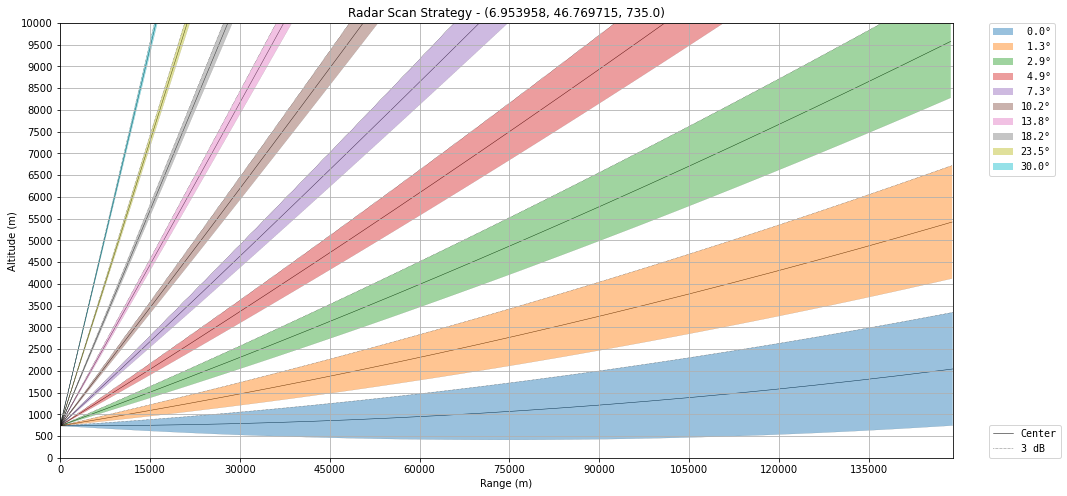

In [9]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords)

We can have it with the terrain derived from SRTM DEM.

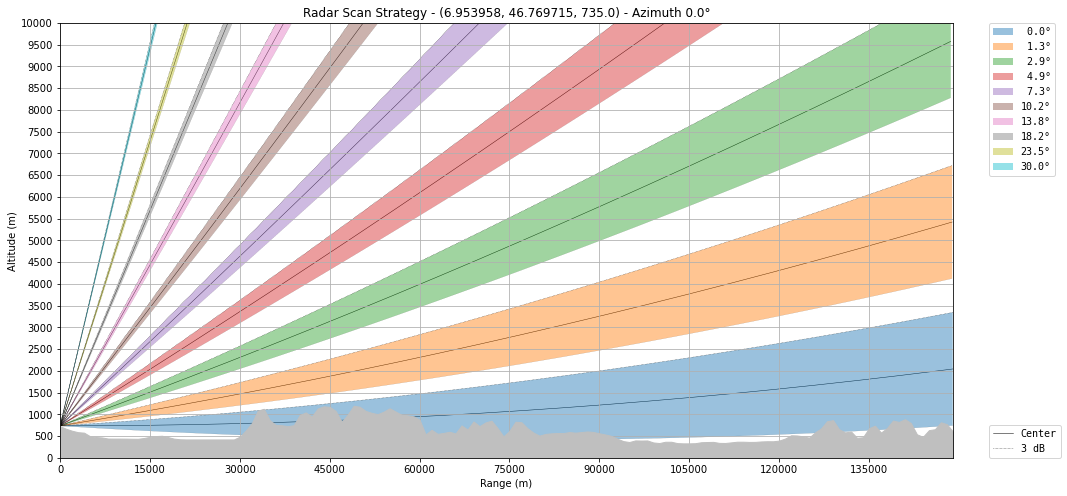

In [10]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, terrain=True)

Let's make the earth go round...

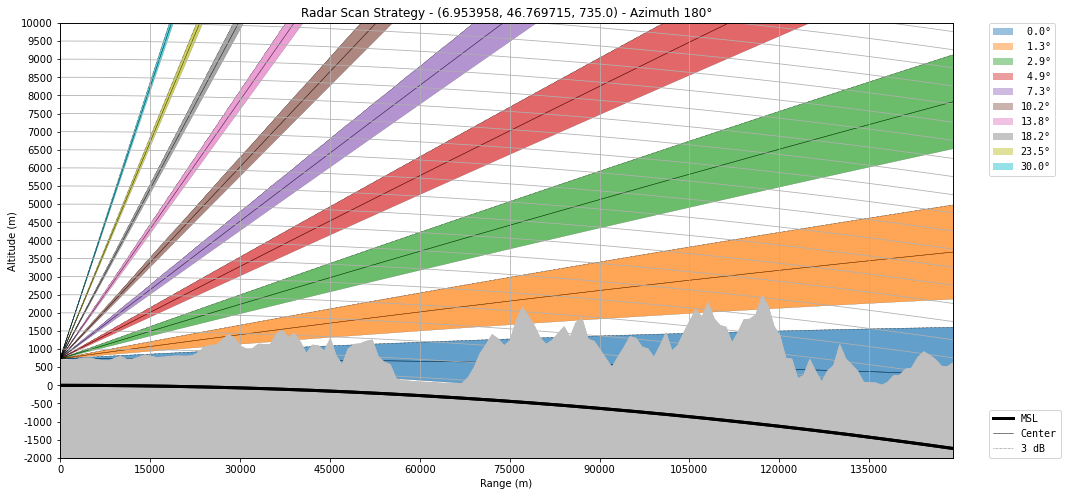

In [11]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, cg=True, terrain=True, az=180 )

### Sweep Groups

Sweeps are available in a sequence attached to the `RadarVolume` object.

In [12]:
swp = vol[0]
display(swp)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1400)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time        datetime64[ns] 2019-10-21T08:24:09
    rtime       (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    sweep_mode  <U20 'azimuth_surveillance'
Data variables:
    DBZH        (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    KDP         (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR         (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

## Basic Plotting
### Time vs. Azimuth

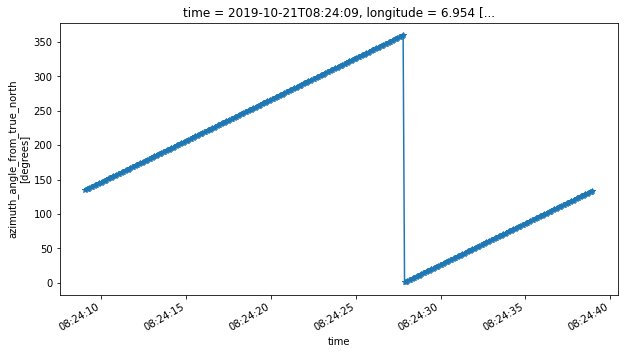

In [13]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
swp.azimuth.sortby("rtime").plot(x="rtime", marker="*")

### Range vs. Azimuth/Time

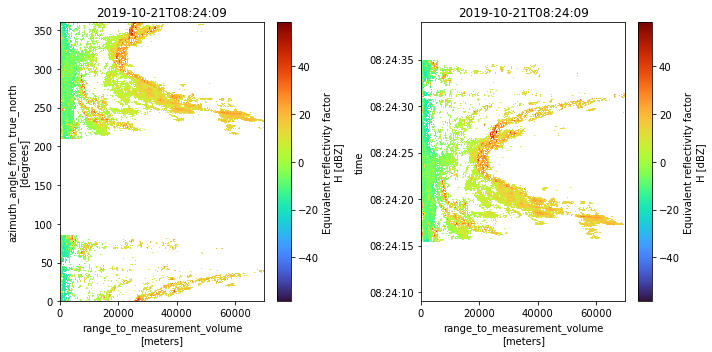

In [14]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
swp.DBZH.plot(cmap='turbo', ax=ax1)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax2 = fig.add_subplot(122)
swp.DBZH.sortby("rtime").plot(y="rtime", cmap='turbo', ax=ax2)
ax2.set_title(f"{swp.time.values.astype('M8[s]')}")
plt.tight_layout()

### Georeferenced as Plan Position Indicator

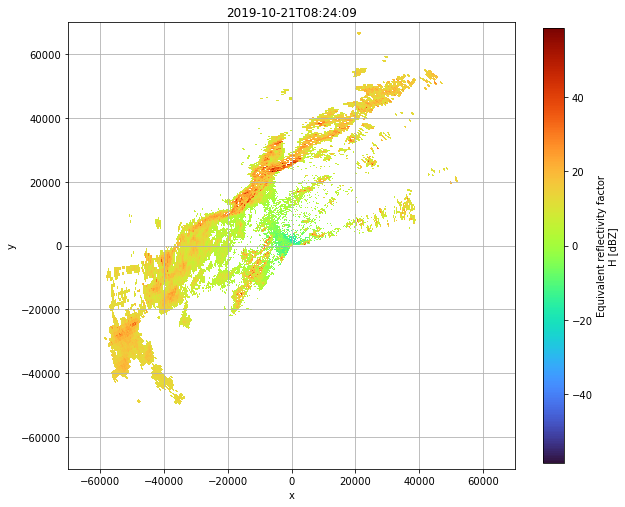

In [15]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(x="x", y="y", ax=ax1, cmap="turbo", cbar_kwargs=dict(shrink=0.8))
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax1.grid()
ax1.set_aspect('equal')

## Basic MapMaking with cartopy

The data will be georeferenced as Azimuthal Equidistant Projection centered at the radar. For the map projection we will use Mercator.

In [16]:
map_trans = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values,
                                      central_longitude=swp.longitude.values)
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)

In [17]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

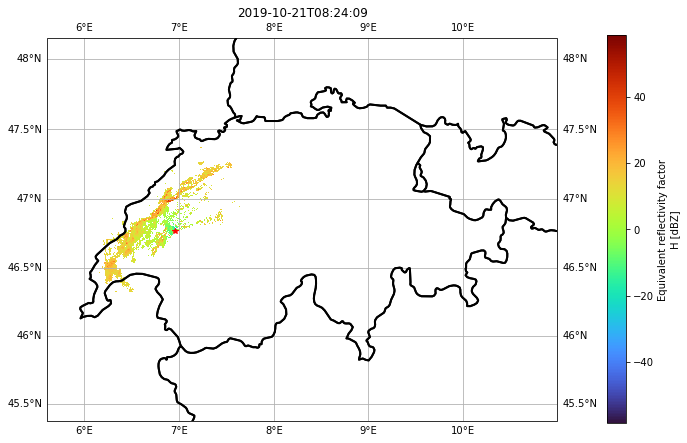

In [18]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
cbar_kwargs = dict(shrink=0.7, pad=0.075)
pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(ax=ax, x="x", y="y", cbar_kwargs=cbar_kwargs, cmap="turbo", transform=map_trans)
plot_borders(ax)
ax.gridlines(draw_labels=True)
ax.plot(swp.longitude.values, swp.latitude.values, transform=map_trans, marker="*", c="r")
ax.set_title(f"{swp.time.values.astype('M8[s]')}")
ax.set_xlim(-15e4, 45e4)
ax.set_ylim(565e4, 610e4)
plt.tight_layout()

## Save to ODIM_H5 format

In [19]:
vol.to_odim("test_odim_vol.h5")

## Re-Open as ODIM_H5

In [20]:
vol2 = wrl.io.open_odim_dataset("test_odim_vol.h5")
display(vol2)

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

In [21]:
display(vol2[0])

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1400)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time        datetime64[ns] 2019-10-21T08:24:09
    sweep_mode  <U20 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.0

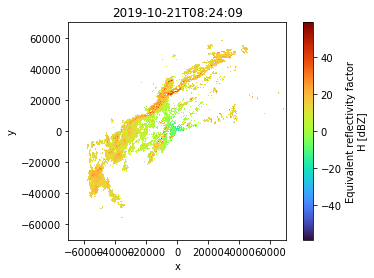

In [22]:
vol[0].DBZH.pipe(wrl.georef.georeference_dataset).plot(x="x", y="y", cmap="turbo")
plt.gca().set_title(f"{vol[0].time.values.astype('M8[s]')}")
plt.gca().set_aspect("equal")

## Using xarray only

We can facilitate the xarray backend's which wradlib provides for the different readers. The xarray backends are capable of loading data into a single Dataset for now. So we need to give some information here too.

### Open single files

The simplest case can only open one file a time!

In [23]:
ds = xr.open_dataset("test_odim_vol.h5", engine="odim", group="dataset1")
display(ds)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1400)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time        datetime64[ns] ...
    sweep_mode  <U20 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Data variables:
    DBZH        (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.0

### Open multiple files

In [24]:
ds = xr.open_mfdataset(nflist[0], engine="rainbow", group=0, combine="by_coords")
display(ds)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1400)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    time        datetime64[ns] 2019-10-21T08:24:09
    rtime       (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    sweep_mode  <U20 'azimuth_surveillance'
Data variables:
    DBZH        (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    KDP         (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH       (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR         (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

---

## Summary
We've just learned how to use $\omega radlib$'s xarray backends to make radar volume data available as xarray Datasets and DataArrays. Accessing, plotting and exporting data has been shown.

### What's next?
In the next notebook we dive into data quality processing.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org)
- [matplotlib](https://matplotlib.org/stable/index.html)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [wradlib scan strategy](https://docs.wradlib.org/en/stable/notebooks/visualisation/wradlib_plot_scan_strategy.html)
- [Leonardo - Rainbow5](https://electronics.leonardo.com/en/products/rainbow-5-application-software)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)